# DETOXIFICATION

In [2]:
%pip install -q torch
%pip install -q transformers[torch]
%pip install -q googletrans==3.1.0a0
%pip install -q fastparquet
%pip install sentencepiece

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 31.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 3.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langsmith 0.1.143 requires httpx<1,>=0.23.0, but you have httpx 0.13.3 which is incompatible.
openai 1.54.4 requires httpx<1,>=0.23.0, but you have httpx 0.13.3 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 M

In [3]:
import pandas as pd
import torch
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from googletrans import Translator
from transformers import Trainer, TrainingArguments, T5Tokenizer, T5ForConditionalGeneration, Seq2SeqTrainer, Seq2SeqTrainingArguments

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Lectura de datos

Vamos a leer el dataset de entrenamiento. Este dataset esta formado por 400 frases tóxicas por idioma en 9 idiomas diferentes y sus versiones no tóxicas. Además hemos añadido un dataset extra con ~19.000 frases en ingles. Formaremos un dataset conjunto que contenga para cada frase, su idioma de origen, la frase tóxica y la frase de-toxificada.

In [6]:
splits = {'en': 'data/en-00000-of-00001.parquet', 'ru': 'data/ru-00000-of-00001.parquet', 'uk': 'data/uk-00000-of-00001.parquet', 'de': 'data/de-00000-of-00001.parquet', 'es': 'data/es-00000-of-00001.parquet', 'am': 'data/am-00000-of-00001.parquet', 'zh': 'data/zh-00000-of-00001.parquet', 'ar': 'data/ar-00000-of-00001.parquet', 'hi': 'data/hi-00000-of-00001.parquet'}
df_en = pd.read_parquet("hf://datasets/textdetox/multilingual_paradetox/" + splits["en"])
df_uk = pd.read_parquet("hf://datasets/textdetox/multilingual_paradetox/" + splits["uk"])
df_ru = pd.read_parquet("hf://datasets/textdetox/multilingual_paradetox/" + splits["ru"])
df_de = pd.read_parquet("hf://datasets/textdetox/multilingual_paradetox/" + splits["de"])
df_es = pd.read_parquet("hf://datasets/textdetox/multilingual_paradetox/" + splits["es"])
df_am = pd.read_parquet("hf://datasets/textdetox/multilingual_paradetox/" + splits["am"])
df_zh = pd.read_parquet("hf://datasets/textdetox/multilingual_paradetox/" + splits["zh"])
df_ar = pd.read_parquet("hf://datasets/textdetox/multilingual_paradetox/" + splits["ar"])
df_hi = pd.read_parquet("hf://datasets/textdetox/multilingual_paradetox/" + splits["hi"])

df_paradetox = pd.read_csv("hf://datasets/s-nlp/paradetox/train.tsv", sep="\t")
df_paradetox.rename(columns={"en_toxic_comment":"toxic_sentence", "en_neutral_comment":"neutral_sentence"}, inplace=True)

df_total = pd.concat([df_en, df_uk, df_ru, df_de, df_es, df_am, df_zh, df_ar, df_hi, df_paradetox], keys=['en','uk', 'ru', 'de', 'es', 'am', 'zh-cn', 'ar', 'hi', 'en']).reset_index(level=[0])
df_total.rename(columns={"level_0":"source_language", "toxic_sentence":"toxic_sentence", "neutral_sentence":"neutral_sentence"}, inplace=True)
df_total.sample(5)

,source_language,toxic_sentence,neutral_sentence
4647,en,but i was still pushing that shit ! ! ! lol im...,"I was still hustling,now am gonna buy a vehicle"
11601,en,"seriously , who gives a shit about his move .",who is concern about what he choosed?
2379,en,you lose credibility and just enable lazy jerks .,You lose credibility and just enable lazy people
19586,en,he 's just a fucking cook !,he is just a cook
13975,en,"if you haven 't noticed , most of the legal sy...","if you haven 't noticed , most of the legal sy..."


## Traducción

Ahora vamos a traducir todo el dataset del idioma al original al ingles, para esto usaremos la librería de google translate.

In [7]:
translator = Translator()

def translate(text, source_lang, dest_lang):
    if source_lang == dest_lang:
        return text

    sol = translator.translate(text , src = source_lang, dest=dest_lang).text
    return sol

In [8]:
df_numpy = df_total.to_numpy()

In [10]:
toxic_translations = []
neutral_translations = []

for sentence in tqdm(df_numpy):
  toxic_translations.append(translate(sentence[1], sentence[0], 'en'))
  neutral_translations.append(translate(sentence[2], sentence[0], 'en'))


df_total["toxic_sentence_en"] = toxic_translations
df_total["neutral_sentence_en"] = neutral_translations

100%|██████████| 23344/23344 [08:29<00:00, 45.78it/s]


In [11]:
df_total.sample(3)

,source_language,toxic_sentence,neutral_sentence,toxic_sentence_en,neutral_sentence_en
8458,en,i like skinny tops & unbuttoned cover - all sh...,i like skinny tops & unbuttoned cover - all sh...,i like skinny tops & unbuttoned cover - all sh...,i like skinny tops & unbuttoned cover - all sh...
8915,en,you tweeting weird shit ! ! lol,You are tweeting weird stuff,you tweeting weird shit ! ! lol,You are tweeting weird stuff
67,ar,مضحك جداً أمر بعض الوافدين ومن ضمنهم مصاروة ! ...,مضحك جداً أمر بعض الوافدين ومن ضمنهم مصريين! ي...,"It's very funny about some of the expatriates,...","Very funny about some expatriates, including E..."


In [12]:
df_total.to_csv("./translated_sentences.csv")

### Train-test split

In [13]:
train, test_and_val = train_test_split(df_total, train_size=0.8, random_state=33)
val, test = train_test_split(test_and_val, train_size=0.5, random_state=33)

X_train = list(train['toxic_sentence_en'])
y_train = list(train['neutral_sentence_en'])

X_val = list(val['toxic_sentence_en'])
y_val = list(val['neutral_sentence_en'])

X_test = list(test['toxic_sentence'])
y_test = list(test['neutral_sentence'])

for i,e in enumerate(y_test):
    if not isinstance(e, str):
        X_test.pop(i)
        y_test.pop(i)

## Pipeline de detoxificación

Nuestro modelo de detoxificación tendrá un pipeline que consistirá de los siguientes pasos:

1. **Traducción**: Traduciremos las frases del idioma original al inglés
2. **Detoxificación**: El modelo detoxificará la frase en inglés
3. **Retro-traducción**: La frase detoxificada será traducida del inglés al idioma original

## Detoxificación

Ahora haremos un finetunning de un modelo de Huggingface para detoxificar el código.

#### Creación de los dataset

In [14]:
class DetoxificationDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, target_encodings):
        self.encodings = encodings
        self.target_encodings = target_encodings

    def __len__(self):
        return len(self.encodings['input_ids'])

    def __getitem__(self, idx):
        item = {key: val[idx].clone().detach() for key, val in self.encodings.items()}
        item['labels'] = self.target_encodings['input_ids'][idx].clone().detach()
        # Reemplazar pad_token_id con -100 para ignorar tokens de relleno en la pérdida
        # item["labels"][item["labels"] == tokenizer.pad_token_id] = -100

        return item

In [15]:
model_name = "google/flan-t5-small"
tokenizer = T5Tokenizer.from_pretrained(model_name)

X_train_tokens = tokenizer(X_train, truncation=True, padding=True, return_tensors="pt")
y_train_tokens = tokenizer(y_train, truncation=True, padding=True, return_tensors="pt")

X_val_tokens = tokenizer(X_val, truncation=True, padding=True, return_tensors="pt")
y_val_tokens = tokenizer(y_val, truncation=True, padding=True, return_tensors="pt")

X_test_tokens = tokenizer(X_test, truncation=True, padding=True, return_tensors="pt")
y_test_tokens = tokenizer(y_test, truncation=True, padding=True, return_tensors="pt")

train_dataset = DetoxificationDataset(X_train_tokens, y_train_tokens)
val_dataset = DetoxificationDataset(X_val_tokens, y_val_tokens)
test_dataset = DetoxificationDataset(X_test_tokens, y_test_tokens)


print("Tamaño del dataset de entrenamiento:", len(train_dataset))
print("Ejemplo del dataset:", train_dataset[0])


tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


Tamaño del dataset de entrenamiento: 18675
Ejemplo del dataset: {'input_ids': tensor([    3,    32,   107,   168,     3,     6,  2763,  8581,  5839,    13,
          175, 25851,   447,  8479,  1052,     8, 13256,    24,  1052,     3,
            6,    43, 11518,     3,     5,     1,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0, 

## Entrenamiento

In [16]:

model = T5ForConditionalGeneration.from_pretrained(model_name)

model.config.task_specific_params={
    "neutralization": {
      "early_stopping": True,
      "length_penalty": 2.0,
      "max_length": 100,
      "min_length": 50,
      "no_repeat_ngram_size": 3,
      "num_beams": 4,
      "prefix": "neutralize: "
    }
}

num_training_layers = 3 # El número de capas que se entrenarán

# Congelar todos los parámetros del modelo
for param in model.parameters():
    param.requires_grad = False

# Descongelar las últimas n capas del decoder
for param in model.decoder.block[-num_training_layers:].parameters():
    param.requires_grad = True

# Mantener la capa de salida (`lm_head`) entrenable
for param in model.lm_head.parameters():
    param.requires_grad = True

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("ESTADÍSTICAS DEL ENTRENAMIENTO:")
print(f"Total de parámetros: {total_params:,}")
print(f"Parámetros entrenables: {trainable_params:,}")
print(f"Parámetros congelados: {total_params - trainable_params:,}")

config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/308M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

ESTADÍSTICAS DEL ENTRENAMIENTO:
Total de parámetros: 76,961,152
Parámetros entrenables: 25,891,328
Parámetros congelados: 51,069,824


In [22]:
from transformers import TrainerCallback
import matplotlib.pyplot as plt

class LossTrackerCallback(TrainerCallback):
    def __init__(self):
        super().__init__()
        self.loss_values = []  # Almacena los valores de loss

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs and "loss" in logs:
            self.loss_values.append((state.global_step, logs["loss"]))  # Guarda (step, loss)

    def plot_loss(self):
        steps, losses = zip(*self.loss_values)
        plt.figure(figsize=(10, 6))
        plt.plot(steps, losses, label="Training Loss")
        plt.xlabel("Step")
        plt.ylabel("Loss")
        plt.title("Loss Evolution During Training")
        plt.legend()
        plt.grid()
        plt.show()

training_args = Seq2SeqTrainingArguments(
    output_dir='./checkpoints',
    # evaluation_strategy="no",
    # evaluation_strategy="epoch",
    evaluation_strategy="steps",
    logging_steps = 20,
    eval_steps=146*5, # cada 5 epochs, teniendo batches de 128
    per_device_train_batch_size=128,
    per_device_eval_batch_size=128,
    learning_rate=2e-4,
    num_train_epochs=25,  # lo maximo intentando no superar el límite de tiempo de google colab
    report_to=["none"], # para no pedir login de 'wandb' y otros
    # fp16=True, # acelera el entrenaminento pero lo empeora
)

loss_tracker = LossTrackerCallback()

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
     callbacks=[loss_tracker],
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Step,Training Loss,Validation Loss
730,0.159100,0.167929
1460,0.147900,0.163588
2190,0.142900,0.162115
2920,0.140300,0.161194
3650,0.136300,0.161187


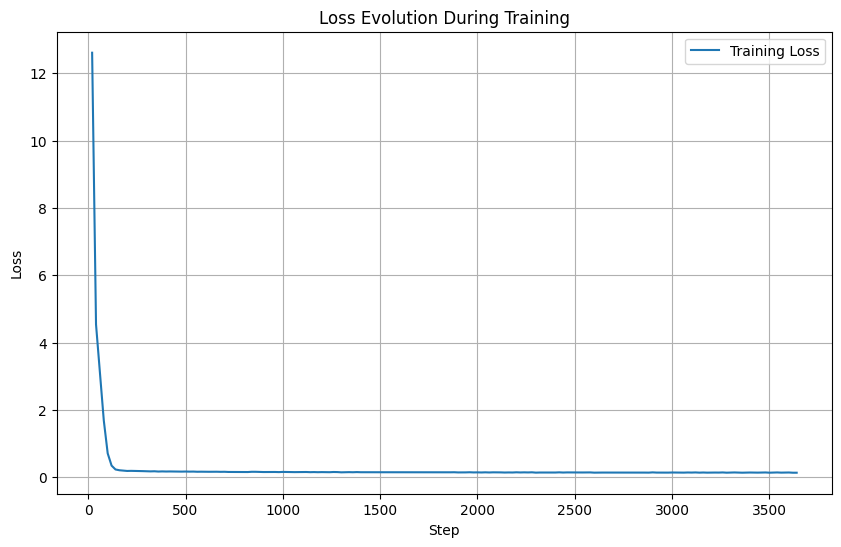

In [23]:
trainer.train()
loss_tracker.plot_loss()

In [38]:
trainer.predict(test_dataset=test_dataset).metrics


OutOfMemoryError: CUDA out of memory. Tried to allocate 1.53 GiB. GPU 0 has a total capacity of 14.75 GiB of which 287.06 MiB is free. Process 10090 has 14.46 GiB memory in use. Of the allocated memory 13.46 GiB is allocated by PyTorch, and 898.14 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [26]:
#guardar
model.save_pretrained("detox_model")

In [30]:
#cargar y probar
loaded_model = T5ForConditionalGeneration.from_pretrained("detox_model")
loaded_model.to(device)

T5ForConditionalGeneration(
  (shared): Embedding(32128, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=384, bias=False)
              (k): Linear(in_features=512, out_features=384, bias=False)
              (v): Linear(in_features=512, out_features=384, bias=False)
              (o): Linear(in_features=384, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 6)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseGatedActDense(
              (wi_0): Linear(in_features=512, out_features=1024, bias=False)
              (wi_1): Linear(in_features=512, out_features=1024, bias=False)
              (wo): 

In [28]:
def detoxify_sentence(sentence, language):
  print(f"FRASE ORIGINAL: {sentence}")
  translated_sentence = translate(sentence, language, 'en')
  input_ids = tokenizer(translated_sentence, return_tensors="pt").input_ids.to(device)
  outputs = loaded_model.generate(input_ids)
  detoxified_sentence = tokenizer.decode(outputs[0], skip_special_tokens=True)
  translated_detoxified_sentence = translate(detoxified_sentence, 'en', language)
  print(f"FRASE DETOXIFICADA: {translated_detoxified_sentence}")
  return translated_detoxified_sentence

In [37]:
sample = df_total[df_total["source_language"] == 'es'].sample(1)
toxic_sentence = sample['toxic_sentence'].iloc[0]
source_language = sample['source_language'].iloc[0]

detoxify_sentence(toxic_sentence, source_language);

FRASE ORIGINAL: La puta que frustración .
FRASE DETOXIFICADA: La persona, qué problema.


In [33]:
sample = df_total[df_total["source_language"] == 'en'].sample(1)
toxic_sentence = sample['toxic_sentence'].iloc[0]
source_language = sample['source_language'].iloc[0]

detoxify_sentence(toxic_sentence, source_language);

FRASE ORIGINAL: hamas alone can 't even get their shit together to be 'one side'
FRASE DETOXIFICADA: Hamas alone can't even get their things together to be 'one side'
